In [11]:
from google.colab import drive
import h5py
import torch
from torch import nn
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


drive.mount('/content/drive')

def Data(file, data_type):
  db = h5py.File(file, 'r')
  im_names = list(db['data'].keys())
  imgs = [db['data'][im][:] for im in im_names]
  if data_type == 'train':
    fonts = [db['data'][im].attrs['font'] for im in im_names]
  txts = [db['data'][im].attrs['txt'] for im in im_names]
  charBBs = [db['data'][im].attrs['charBB'] for im in im_names]
  wordBBs = [db['data'][im].attrs['wordBB'] for im in im_names]

  imgs = ([img.transpose(2, 0, 1) for img in imgs])
  charBBs = ([charBB.transpose(2, 0, 1) for charBB in charBBs])

  if data_type == 'train':
    return imgs, charBBs, fonts
  else:
    return im_names, imgs, charBBs, txts




file = '/content/drive/My Drive/Project/train.h5'
train_imgs, train_charBBs, train_fonts = Data(file, 'train')


file = '/content/drive/My Drive/Project/test.h5'
test_im_names, test_imgs, test_charBBs, test_text = Data(file, 'test')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


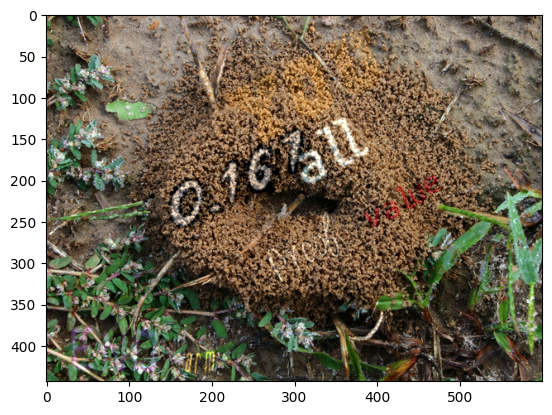

In [22]:
from torchvision import transforms
import numpy as np

plt.imshow(train_imgs[0].transpose(1, 2, 0))
plt.show()
map_dict = {0: 'Flower Rose Brush',
            1: 'Skylark',
            2: 'Sweet Puppy',
            3: 'Ubuntu Mono',
            4: 'VertigoFLF',
            5: 'Wanted M54',
            6: 'always forever'}

# Create a reverse mapping for efficient font number lookup
font_number_map = {value: key for key, value in map_dict.items()}

def get_font_number(font):
    return font_number_map.get(font, -1)  # Return a default value if font not found



cropped_transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(2.5, 3.5)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
])


def get_train_data(imgs, charBBs, fonts):
    char_image_list = []
    font_numbers_list = []
    img_size = 105
    for i, img in enumerate(imgs):
      for box, font in zip(charBBs[i], fonts[i]):
        x1, y1 = box[0][0], box[1][0]
        x2, y2 = box[0][1], box[1][1]
        x3, y3 = box[0][2], box[1][2]
        x4, y4 = box[0][3], box[1][3]
        src_pts = np.float32([[x1, y1], [x2, y2], [x4, y4], [x3, y3]])
        dst_pts = np.float32([[0, 0], [img_size, 0], [0, img_size], [img_size, img_size]])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        char = cv2.warpPerspective(img.transpose(1, 2, 0), M, (img_size, img_size))
        char = data_augmentation(char)
        char = char.transpose(2, 0, 1)
        char = torch.Tensor(char)
        char_image_list.append(char.unsqueeze(0))
        font_numbers_list.append(get_font_number(font))
    chars = torch.cat(char_image_list, dim=0)
    font_numbers = torch.tensor(font_numbers_list)
    return chars, font_numbers

def get_test_data(im_names, imgs, charBBs, txts):
  char_image_list = []
  name_list = []
  txt_list = []
  img_size = 105
  for i, img in enumerate(imgs):
    image_txt = [letter for word in txts[i] for letter in word.decode()]
    for box, txt in zip(charBBs[i], image_txt):
      x1, y1 = box[0][0], box[1][0]
      x2, y2 = box[0][1], box[1][1]
      x3, y3 = box[0][2], box[1][2]
      x4, y4 = box[0][3], box[1][3]
      src_pts = np.float32([[x1, y1], [x2, y2], [x4, y4], [x3, y3]])
      dst_pts = np.float32([[0, 0], [img_size, 0], [0, img_size], [img_size, img_size]])
      M = cv2.getPerspectiveTransform(src_pts, dst_pts)
      char = cv2.warpPerspective(img.transpose(1, 2, 0), M, (img_size, img_size))
      char = char.transpose(2, 0, 1)
      char = torch.Tensor(char)
      char_image_list.append(char.unsqueeze(0))
      name_list.append(im_names[i])
      txt_list.append(txt)

  chars = torch.cat(char_image_list, dim=0)
  return name_list, chars, txt_list

def data_augmentation(img):
  noisy_image = img + np.random.normal(0, 5, img.shape)
  blurred_image = cv2.GaussianBlur(noisy_image, (3, 3), 0)
  return blurred_image

train_character_images, train_labels = get_train_data(train_imgs, train_charBBs, train_fonts)
test_image_names, test_character_images, test_txts = get_test_data(test_im_names, test_imgs, test_charBBs, test_text)

In [40]:
num_classes = 7
class FontClassifier(nn.Module):
  def __init__(self):
    super().__init__()

     # VGG layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(in_features=512*13*13, out_features=786)
    self.fc2 = nn.Linear(in_features=786, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    layer_1 = self.relu(self.conv1(x))
    layer_2 = self.MaxPooling(self.relu(self.conv2(layer_1)))
    layer_3 = self.relu(self.conv3(layer_2))
    layer_4 = self.MaxPooling(self.relu(self.conv4(layer_3)))
    layer_5 = self.relu(self.conv5(layer_4))
    layer_6 = self.relu(self.conv6(layer_5))
    layer_7 = self.MaxPooling(self.relu(self.conv7(layer_6)))
    layer_8 = self.relu(self.conv8(layer_7))
    layer_9 = self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.flatten(layer_8))))))

    return layer_9




In [41]:
model = FontClassifier().to('cuda')
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [42]:
train_data = torch.utils.data.TensorDataset(train_character_images, train_labels)
test_data = torch.utils.data.TensorDataset(test_character_images)

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [16]:
!pip install torchmetrics
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy("multiclass", num_classes=num_classes).to("cuda")

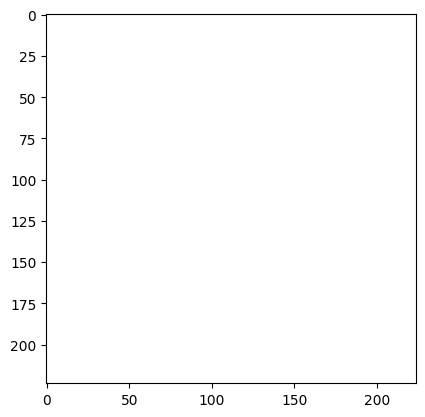

In [17]:
plt.imshow(train_character_images[5].permute(1, 2, 0))
plt.show()

In [43]:
torch.manual_seed(42)
epochs = 30

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to('cuda'), y.to('cuda')
    model.train()
    # 1. Forward pass

    y_pred = model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn (y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += torchmetric_accuracy(y,y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_acc /= len(train_dataloader)
  train_loss /= len(train_dataloader)

  # Print out what's happening
  print(f"\n Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc}")

  0%|          | 0/30 [00:00<?, ?it/s]


 Epoch: 0 | Train loss: 1.8716 | Train acc: 0.22349855303764343

 Epoch: 1 | Train loss: 1.0896 | Train acc: 0.6200252771377563

 Epoch: 2 | Train loss: 0.5407 | Train acc: 0.8235347270965576

 Epoch: 3 | Train loss: 0.3573 | Train acc: 0.8816931843757629

 Epoch: 4 | Train loss: 0.2577 | Train acc: 0.9155662059783936

 Epoch: 5 | Train loss: 0.1914 | Train acc: 0.9363693594932556

 Epoch: 6 | Train loss: 0.1719 | Train acc: 0.9448263049125671

 Epoch: 7 | Train loss: 0.1337 | Train acc: 0.9563133120536804

 Epoch: 8 | Train loss: 0.1273 | Train acc: 0.9602929949760437

 Epoch: 9 | Train loss: 0.0908 | Train acc: 0.9710564017295837

 Epoch: 10 | Train loss: 0.0968 | Train acc: 0.9702423810958862

 Epoch: 11 | Train loss: 0.0768 | Train acc: 0.9771164655685425

 Epoch: 12 | Train loss: 0.0702 | Train acc: 0.9805987477302551

 Epoch: 13 | Train loss: 0.0625 | Train acc: 0.9816389083862305

 Epoch: 14 | Train loss: 0.0578 | Train acc: 0.983402669429779

 Epoch: 15 | Train loss: 0.0516 | 

In [44]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images):
    self.images = images  # Store the images tensor

  def __len__(self):
    return len(self.images)  # Return total number of images

  def __getitem__(self, idx):
    return self.images[idx]  # Return the image at the given index

test_dataset = ImageDataset(test_character_images)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.inference_mode():
  all_predictions = []
  for X in test_loader:
    X = X.to("cuda")
    test_pred = model(X)
    test_pred_np = test_pred.cpu().numpy()
    batch_predictions = np.argmax(test_pred_np, axis=1)
    all_predictions.extend(batch_predictions)
string_predictions = [
    {"0": "Flower Rose Brush",
     "1": "Skylark",
     "2": "Sweet Puppy",
     "3": "Ubuntu Mono",
     "4": "VertigoFLF",
     "5": "Wanted M54",
     "6": "always forever"}[str(pred)]
    for pred in all_predictions
]



In [45]:
import pandas as pd
df = pd.DataFrame(data={'image': test_image_names, 'char': test_txts, 'font': string_predictions})
df.to_csv('my_data.csv', index=True)

In [46]:
def submit_predictions(string_predictions):
    df = pd.DataFrame(string_predictions)
    df['Index'] = range(len(df))
    new_df = pd.DataFrame({'ind': df['Index'], 'font': string_predictions})
    new_df.to_csv("submission.csv", index=False)

In [47]:
submit_predictions(all_predictions)